# Установка catboost, shap
# Импорт модулей

In [1]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import shap

# Загрузка данных

Получаем

*   train_df
*   test_df



In [240]:
train_df = pd.read_csv('/content/drive/MyDrive/Stepic_ML/Stepic_contest/df/train_df_sf.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stepic_ML/Stepic_contest/df/test_df_sf.csv')

# Создание X_train, y_train, X_test

In [241]:
X_train = train_df.drop(['passed_course', 'first_timestamp_event', 'first_timestamp_submission'], axis=1)
y_train = train_df['passed_course']
X_test = test_df.drop(['first_timestamp_event', 'first_timestamp_submission'], axis=1)
test_user_id = test_df['user_id']

# Train_test_split

In [242]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.2, random_state=42,
                                                      stratify=y_train)

In [243]:
X_train_.shape

(15387, 48)

In [244]:
X_train_ev, X_eval, y_train_ev, y_eval = train_test_split(X_train_, y_train_, 
                                                  test_size=0.4, random_state=0, 
                                                  stratify=y_train_)

In [245]:
X_train_ev.shape

(9232, 48)

In [246]:
clm = list(X_val.columns)

# CBC_baseline

In [247]:
cbc_baseline = CatBoostClassifier(silent=True,
                             early_stopping_rounds=20,
                             eval_metric='AUC',
                             loss_function ='Logloss',
                             iterations=20,
                             use_best_model=True)

In [248]:
cbc_baseline.fit(X_train_ev, y_train_ev, eval_set=(X_eval, y_eval))

# Метрики cbc_baseline

In [249]:
cbc_baseline.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 20,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': ['False', 'True'],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logl

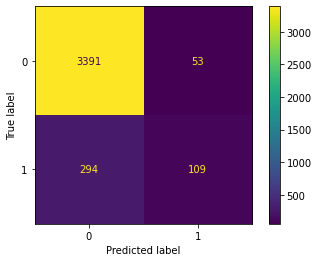

In [250]:
cmd = confusion_matrix(y_val, pd.DataFrame(cbc_baseline.predict(X_val)).replace({'False': ''}).astype(bool))
ConfusionMatrixDisplay(cmd).plot()

In [251]:
f1_score(y_val, pd.DataFrame(cbc_baseline.predict(X_val)).replace({'False': ''}).astype(bool))

0.38584070796460174

In [252]:
cbc_baseline.score(X_val, y_val.astype(str))

0.9097998440343125

In [253]:
auc = roc_auc_score(y_val, cbc_baseline.predict_proba(X_val)[:,1])
auc

0.8989183187648961

# Поиск параметров CBC

In [254]:
cbc_cv = CatBoostClassifier(silent=True,
                            early_stopping_rounds=20,
                            eval_metric = 'AUC',
                            loss_function ='Logloss')

In [255]:
cv_params = {'iterations': range(5, 50, 5),
             'learning_rate': np.arange(0.1, 0.5, 0.1),
             'depth': range(3, 10, 1),
             'min_child_samples': range(1, 10, 1),
             'l2_leaf_reg': np.arange(2, 5, 1),
             #'bagging_temperature': range(5, 7, 1),
             #'random_strength': np.arange(0.1, 2, 0.5),
             'leaf_estimation_method': ['Newton','Gradient','Exact'],
             'auto_class_weights': [None,'SqrtBalanced', 'Balanced'],
             'penalties_coefficient': np.arange(0.5,2,0.5)
             }

In [256]:
cbc_cv_res = cbc_cv.randomized_search(cv_params, X_train_, y_train_, 
                                   cv=5, 
                                   train_size=0.66,
                                   n_iter=300,
                                   partition_random_seed=42,
                                   stratified=True)


bestTest = 0.8721242088
bestIteration = 2

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8721242	best: 0.8721242 (0)	total: 94.8ms	remaining: 28.3s

bestTest = 0.8822363871
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8822364	best: 0.8822364 (1)	total: 159ms	remaining: 23.7s

bestTest = 0.8816933417
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8816933	best: 0.8822364 (1)	total: 224ms	remaining: 22.1s

bestTest = 0.8789137883
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8789138	best: 0.8822364 (1)	total: 294ms	remaining: 21.7s

bestTest =

# Метрики cv

In [257]:
cbc_cv.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 35,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Gradient',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 0.5,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 2,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 20,
 'class_names': ['False', 'True'],
 'random_seed': 0,
 'depth': 5,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 2.925259590148926],
 'classes_count': 0,
 'auto_class_weights': 'SqrtBalanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_ra

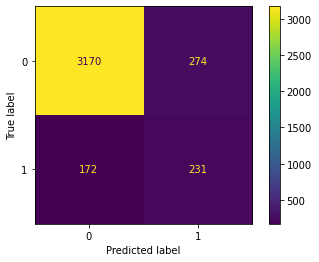

In [258]:
cmd = confusion_matrix(y_val, pd.DataFrame(cbc_cv.predict(X_val)).replace({'False': ''}).astype(bool))
ConfusionMatrixDisplay(cmd).plot()

In [262]:
f1_score(y_val, pd.DataFrame(cbc_cv.predict(X_val)).replace({'False': ''}).astype(bool))

0.5088105726872246

In [263]:
cbc_cv.score(X_val, y_val.astype(str))

0.8840655055887705

In [264]:
auc = roc_auc_score(y_val, cbc_cv.predict_proba(X_val)[:,1])
auc

0.8947704210292722

# Выбор фичей RFECV

In [111]:
cbc_clf_RFECV = CatBoostClassifier(silent=True,
                             early_stopping_rounds=20,
                             eval_metric = 'AUC',
                             loss_function ='Logloss',
                             iterations=20)

In [112]:
RFECV_cbc = RFECV(cbc_clf_RFECV, n_jobs=-1,
                  step = 1,
                  min_features_to_select=round(len(clm) * 0.8))
RFECV_cbc.fit(X_train_ev, y_train_ev.astype(str))
selected_features = RFECV_cbc.get_feature_names_out()

In [113]:
X_train_dropped = X_train_[selected_features]
X_train_ev_dropped = X_train_ev[selected_features]
X_eval_dropped = X_eval[selected_features]
X_val_dropped = X_val[selected_features]
X_test_dropped = X_test[selected_features]

In [114]:
X_train_dropped.shape

(14425, 47)

# Baseline with selected features

In [115]:
cbc_RFECV = CatBoostClassifier(silent=True,
                             early_stopping_rounds=20,
                             eval_metric = 'AUC',
                             loss_function ='Logloss',
                             iterations=20)

In [116]:
cbc_RFECV.fit(X_train_ev_dropped, y_train_ev, eval_set=(X_eval_dropped, y_eval))

# Метрики cbc_RFECV

In [117]:
cbc_RFECV.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 20,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': ['False', 'True'],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logl

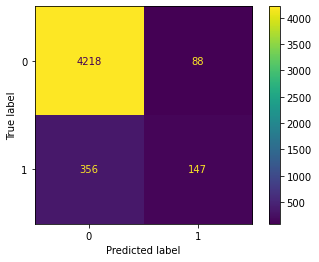

In [118]:
cmd = confusion_matrix(y_val, pd.DataFrame(cbc_RFECV.predict(X_val_dropped)).replace({'False': ''}).astype(bool))
ConfusionMatrixDisplay(cmd).plot()

In [119]:
f1_score(y_val, pd.DataFrame(cbc_RFECV.predict(X_val_dropped)).replace({'False': ''}).astype(bool))

0.39837398373983746

In [120]:
cbc_RFECV.score(X_val_dropped, y_val.astype(str))

0.9076731129132876

In [121]:
auc = roc_auc_score(y_val, cbc_RFECV.predict_proba(X_val_dropped)[:,1])
auc

0.89476609917827

# SHAP на лучшей модели


In [231]:
best_clf = cbc_cv

In [232]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_val)

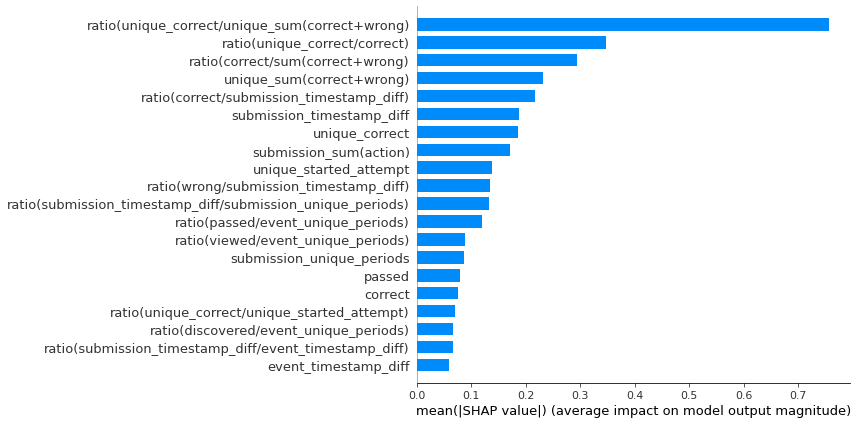

In [233]:
shap.summary_plot(shap_values, X_val, plot_type="bar", plot_size=(12,6))

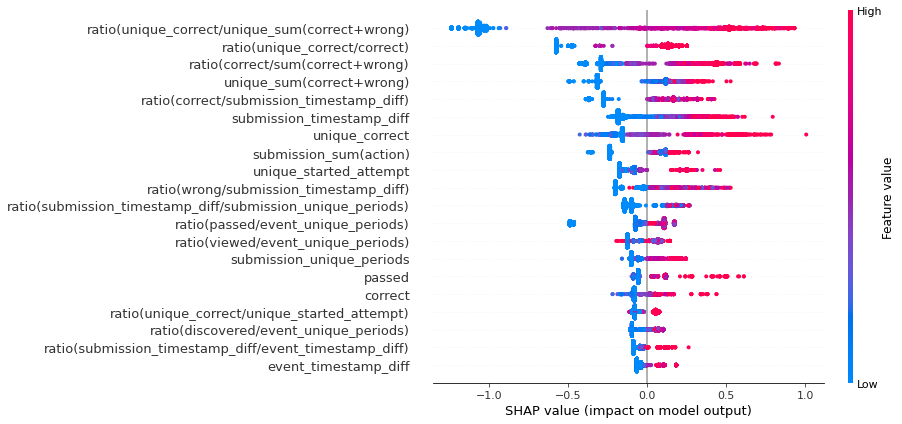

In [234]:
shap.summary_plot(shap_values, X_val, plot_size=(13,6))

In [224]:
pd.DataFrame(shap_values, columns = clm).mean()\
.sort_values(ascending=False)

unique_sum(correct+wrong)                                     0.041784
ratio(unique_correct/unique_sum(correct+wrong)                0.028357
ratio(viewed/event_unique_periods)                            0.020577
ratio(submission_sum(action)/submission_unique_periods)       0.016766
ratio(submission_timestamp_diff/event_timestamp_diff)         0.009763
submission_sum(action)                                        0.009005
ratio(wrong/submission_timestamp_diff)                        0.007089
ratio(unique_sum(correct+wrong)/unique_started_attempt)       0.003754
correct                                                       0.003313
ratio(started_attempt/event_timestamp_diff)                   0.003174
passed                                                        0.003075
unique_started_attempt                                        0.003044
unique_correct                                                0.002909
days                                                          0.000442
event_

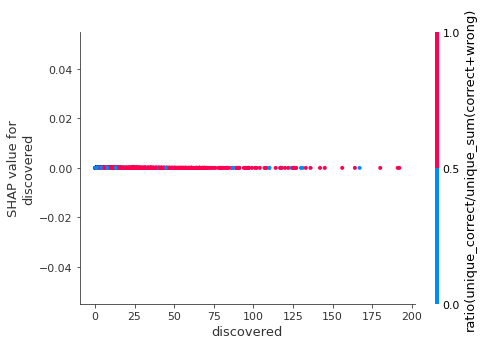

In [225]:
shap.dependence_plot(clm[1], shap_values, X_val, show=True, 
                     interaction_index='ratio(unique_correct/unique_sum(correct+wrong)'
                     )
#pl.xlim(0,200)
#pl.show()

# Предсказание X_test на лучшей модели

In [235]:
predict = best_clf.predict_proba(X_test)[:,1]

In [236]:
result = pd.DataFrame(test_user_id)
result['is_gone'] = predict

In [237]:
pd.DataFrame(best_clf.predict(X_test)).value_counts()

False    4203
True     1981
dtype: int64

In [239]:
path = f'/content/drive/MyDrive/Stepic_ML/Stepic_contest/{auc:.5f}cbc_result.csv'
with open(path, 'w+', encoding = 'utf-8-sig') as f:
    result.to_csv(f, index=False)

In [238]:
result

,user_id,is_gone
0,4,0.004688
1,6,0.004688
2,10,0.004787
3,12,0.290979
4,13,0.890079
...,...,...
6179,26791,0.004392
6180,26795,0.004392
6181,26796,0.300739
6182,26799,0.525347
